In [1]:
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent / "src"))
import torch
import torch.nn as nn
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

from config import *
from train import train_one_epoch
from evaluate import evaluate
from predict import predict_folder

In [2]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [3]:
train_dataset = datasets.ImageFolder(DATA_DIR / "train", transform=train_transform)
val_dataset   = datasets.ImageFolder(DATA_DIR / "val", transform=val_test_transform)
test_dataset  = datasets.ImageFolder(DATA_DIR / "test", transform=val_test_transform)

class_names = train_dataset.classes
num_classes = len(class_names)

In [4]:
with open(CLASSES_PATH, "w", encoding="utf-8") as f:
    for c in class_names:
        f.write(c + "\n")

In [5]:
labels = [label for _, label in train_dataset.samples]

eda_df = pd.DataFrame({
    "class": class_names,
    "num_images": [
        labels.count(i) for i in range(len(class_names))
    ]
})

eda_df

,class,num_images
0,butterfly,1170
1,cat,1170
2,chicken,1170
3,cow,1170
4,dog,1170
5,elephant,1170
6,horse,1170
7,monkey,1170
8,sheep,1170
9,spider,1170


In [6]:
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img * std + mean

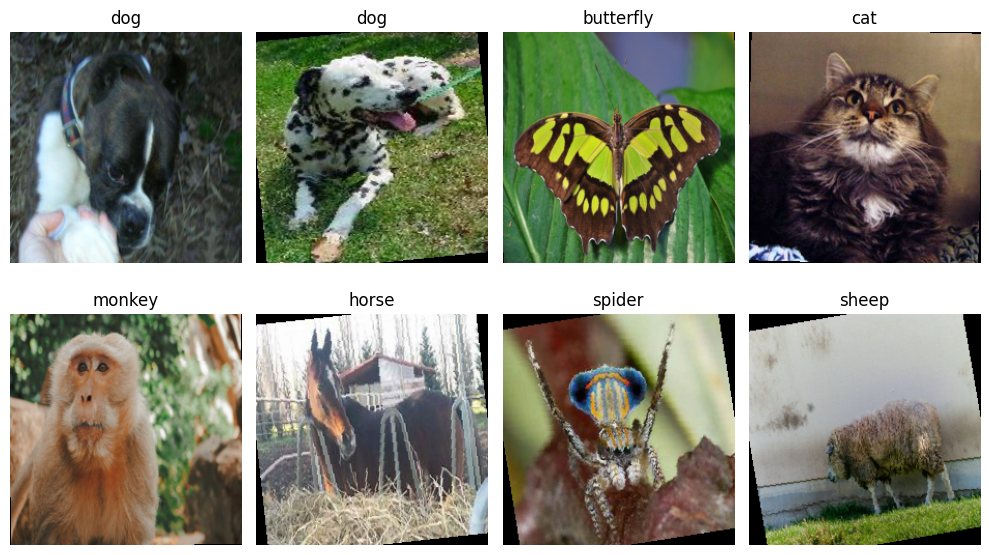

In [7]:
plt.figure(figsize=(10, 6))

indices = random.sample(range(len(train_dataset)), 8)

for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = unnormalize(img).permute(1, 2, 0)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

C:\Users\admin\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\admin\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

In [11]:
SAVED_MODELS_DIR.mkdir(exist_ok=True)
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"[{epoch+1}/{EPOCHS}] "
          f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVED_MODELS_DIR / "best_model.pt")

[1/5] Train Acc: 0.8717 | Val Acc: 0.9278
[2/5] Train Acc: 0.9248 | Val Acc: 0.9264
[3/5] Train Acc: 0.9368 | Val Acc: 0.9385
[4/5] Train Acc: 0.9373 | Val Acc: 0.9357
[5/5] Train Acc: 0.9419 | Val Acc: 0.9400


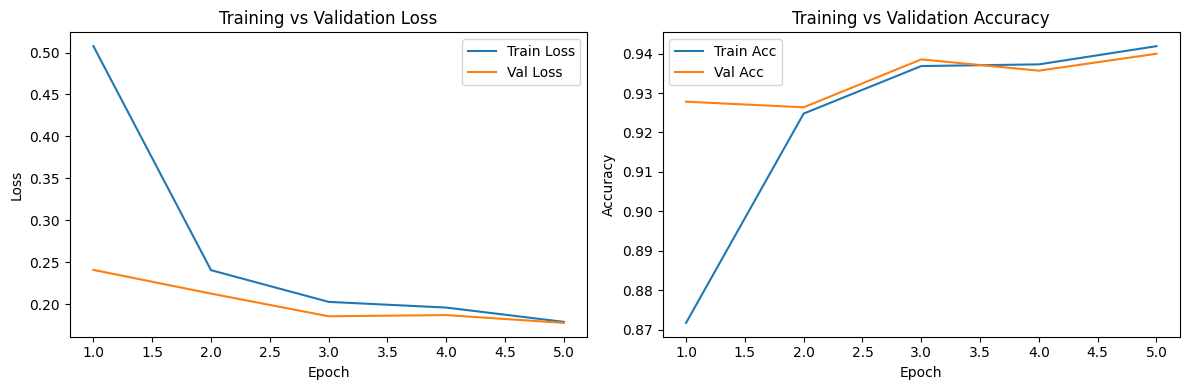

In [12]:
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
best_model = models.resnet18(pretrained=False)
best_model.fc = nn.Linear(best_model.fc.in_features, num_classes)

best_model.load_state_dict(
    torch.load(SAVED_MODELS_DIR / "best_model.pt", map_location=device)
)
best_model = best_model.to(device)

test_loss, test_acc = evaluate(best_model, test_loader, criterion, device)
print("Test Accuracy:", test_acc)

C:\Users\admin\miniconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\admin\AppData\Local\Temp\ipykernel_12264\3833950088.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user vi

Test Accuracy: 0.93


In [14]:
all_preds = []
all_labels = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

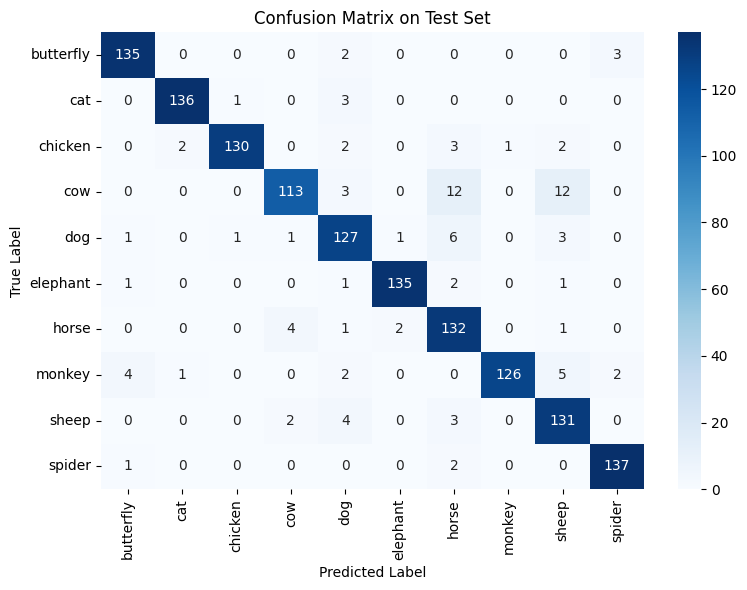

In [15]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()

In [16]:
class_accuracy = cm.diagonal() / cm.sum(axis=1)

df_class_acc = pd.DataFrame({
    "Class": class_names,
    "Accuracy": class_accuracy
}).sort_values(by="Accuracy", ascending=False)

df_class_acc

,Class,Accuracy
9,spider,0.978571
1,cat,0.971429
0,butterfly,0.964286
5,elephant,0.964286
6,horse,0.942857
8,sheep,0.935714
2,chicken,0.928571
4,dog,0.907143
7,monkey,0.900000
3,cow,0.807143


In [17]:
misclassified = []

best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = best_model(images)
        preds = outputs.argmax(dim=1)

        for img, pred, label in zip(images, preds, labels):
            if pred != label:
                misclassified.append(
                    (img.cpu(), pred.cpu(), label.cpu())
                )

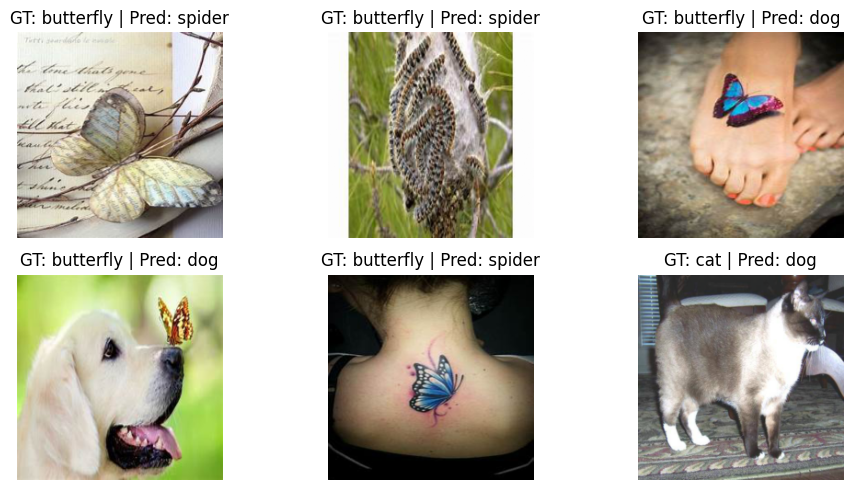

In [18]:
if len(misclassified) > 0:
    plt.figure(figsize=(10,5))
    for i, (img, pred, label) in enumerate(misclassified[:6]):
        img = unnormalize(img).permute(1,2,0)

        plt.subplot(2,3,i+1)
        plt.imshow(img)
        plt.title(f"GT: {class_names[label]} | Pred: {class_names[pred]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified samples found in test set.")

In [19]:
results = predict_folder(
    best_model,
    PREDICT_DIR,
    class_names,
    val_test_transform,
    device,
    topk=3
)

for img, preds in results.items():
    print(f"\n{img}")
    for label, prob in preds:
        print(f"  {label}: {prob:.4f}")


butter01.jpg
  butterfly: 0.9770
  cat: 0.0163
  dog: 0.0048

cat01.jpg
  cat: 0.9998
  butterfly: 0.0002
  spider: 0.0000

chicken01.jpg
  chicken: 0.9999
  horse: 0.0000
  butterfly: 0.0000

cow01.jpg
  cow: 0.9305
  horse: 0.0622
  sheep: 0.0059

dog01.jpg
  dog: 0.9993
  sheep: 0.0006
  elephant: 0.0001

dog02.jpg
  dog: 0.9410
  spider: 0.0220
  cow: 0.0096

dog03.jpg
  dog: 0.9963
  cat: 0.0032
  butterfly: 0.0005

elephant01.jpg
  elephant: 1.0000
  sheep: 0.0000
  horse: 0.0000

spider01.jpg
  spider: 1.0000
  butterfly: 0.0000
  chicken: 0.0000
